In [1]:
from typing import List, Dict, Tuple

import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

__WORKING_BRANCH_PATH = (
    "/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch"
)

hatch = {
    'Vector': '',
    'Skiplist': '\\\\\\\\\\\\',
    'Hashskiplist': '//',
    'Hashlinklist': '----'
}

linestyle = {
    'Vector': '-',
    'Skiplist': '-',
    'Hashskiplist': '-.',
    'Hashlinklist': '..'
}

alpha = {
    'Vector': 1,
    'Skiplist': 0.6,
    'Hashskiplist': 1,
    'Hashlinklist': 0.8
}

color = {
    # 'Vector': 'darkslateblue',
    # 'Skiplist': 'olive',
    # 'Hashskiplist': 'darkred',
    # 'Hashlinklist': 'steelblue'
    # 'Vector': 'black',
    # 'Skiplist': 'black',
    # 'Hashskiplist': 'black',
    # 'Hashlinklist': 'black'
}

edgecolor = {
    'Vector': 'black',
    'Skiplist': 'black',
    'Hashskiplist': 'black',
    'Hashlinklist': 'black'
}

label = {
    'Vector': 'vector',
    'Skiplist': 'skiplist',
    'Hashskiplist': 'hash skiplist',
    'Hashlinklist': 'hash linklist'
}

plt.rcParams["font.family"] = "serif"

alphabets = "abcdefghijklmnopqrstuvwxyz"

def get_properties(key: str) -> Dict[str, str]:
    if key.capitalize() in label:
        return {
            # "label": label.get(key.capitalize()),
            "color": color.get(key.capitalize()) or "None",
            "edgecolor": edgecolor.get(key.capitalize()) or "None",
            # "linestyle": linestyle.get(key.capitalize()),
            "hatch": hatch.get(key.capitalize()),
            "alpha": alpha.get(key.capitalize()),
        }
    else:
        raise ValueError(f"Unknown key: {key}")


In [2]:
def get_exp_dirname(query_type: str, selectivity: float, entry_size: int) -> str:
    return (
        f"{__WORKING_BRANCH_PATH}/experiments-{query_type}-{selectivity}-{entry_size}"
    )


def get_log_dirname(
    query_type: str,
    inserts: int,
    point_queries: int,
    range_queries: int,
    selectivity: float,
    memtable: str,
    entry_size: int,
    number_of_entries_per_page: int,
    number_of_pages: int,
    prefixlen: int = 0,
    bucket_count: int = 0,
    size_ratio: int = 4,
    updates: int = 0,
):
    if memtable.lower() in ("hashskiplist", "hashlinklist"):
        return f"{get_exp_dirname(query_type, selectivity, entry_size)}/I {inserts} U {updates} S {range_queries} Y {selectivity} Q {point_queries} m {memtable.lower()} E {entry_size} B {number_of_entries_per_page} P {number_of_pages} T {size_ratio} l {prefixlen} bucket_count {bucket_count}"
    return f"{get_exp_dirname(query_type, selectivity, entry_size)}/I {inserts} U {updates} S {range_queries} Y {selectivity} Q {point_queries} m {memtable.lower()} E {entry_size} B {number_of_entries_per_page} P {number_of_pages} T {size_ratio}"

In [3]:
def process_log_file(
    log_file: str, logs_dict: dict, index, key: str = "", key_to_search: str = ""
):
    with open(log_file + "/workload.log", "r") as ff:
        for line in ff.readlines():
            if line.startswith(key_to_search):
                temp_line = line.strip(key_to_search)
                logs_dict[key] = int(temp_line.split(" ")[index])
                break

def process_flush_stats(log_dir: str, logs_dict: dict):
    filepath = f"{log_dir}/flush_stats.csv"

    df = pd.read_csv(filepath)
    logs_dict["TotalFlushes"] = df.shape[0] - 1
    logs_dict["entriesLeft"] = df.iloc[-1]["NumEntries"]

def autolabel(rectangle_group, ax, value):
    for rect in rectangle_group:
        height = rect.get_height()
        ax.annotate(f"{value/1000:.2f}K$^+$",
                xy = (rect.get_x() + rect.get_width() / 2, height),
                ha='center', color = 'black', rotation=90, xytext=(0,5), textcoords="offset points")


/tmp/ipykernel_870524/1888356852.py:158: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels([f"{int(i/(1000*1000))}" for i in ax[0].get_yticks()], fontsize=11)


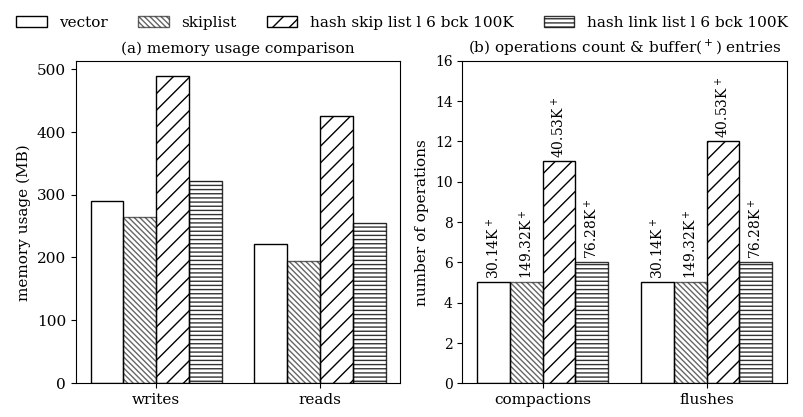

In [8]:
query_type = "FLUSH"
entry_size = 64
memtables = ["Vector", "SkipList", "Hashskiplist", "Hashlinklist"]
inserts = 1000000
point_queries = 0
range_queries = 0
number_of_entries_per_page = 64
number_of_pages = 4096
updates = 0
prefixlen = 6
bucket_count = 100000

selectivities = [0]
list_memdf1 = []
list_memdf2 = []
titles = []

for selectivity in selectivities:
    vec_logdir = get_log_dirname(
        query_type,
        inserts,
        point_queries,
        range_queries,
        selectivity,
        memtables[0],
        entry_size,
        number_of_entries_per_page,
        number_of_pages,
        prefixlen,
        bucket_count,
    )

    skip_logdir = get_log_dirname(
        query_type,
        inserts,
        point_queries,
        range_queries,
        selectivity,
        memtables[1],
        entry_size,
        number_of_entries_per_page,
        number_of_pages,
        prefixlen,
        bucket_count,
    )

    hash_skip_logdir = get_log_dirname(
        query_type,
        inserts,
        point_queries,
        range_queries,
        selectivity,
        memtables[2],
        entry_size,
        number_of_entries_per_page,
        number_of_pages,
        prefixlen,
        bucket_count,
    )

    hash_link_logdir = get_log_dirname(
        query_type,
        inserts,
        point_queries,
        range_queries,
        selectivity,
        memtables[3],
        entry_size,
        number_of_entries_per_page,
        number_of_pages,
        prefixlen,
        bucket_count,
    )


    vec_stats = dict()
    skip_stats = dict()
    hash_skip_stats = dict()
    hash_link_stats = dict()

    process_log_file(vec_logdir, vec_stats, 0, "CompactReads", "rocksdb.compact.read.bytes COUNT : ")
    process_log_file(vec_logdir, vec_stats, 0, "CompactWrites", "rocksdb.compact.write.bytes COUNT : ")
    process_log_file(vec_logdir, vec_stats, 0, "FlushWrites", "rocksdb.flush.write.bytes COUNT : ")
    process_log_file(vec_logdir, vec_stats, 14, "NumCompactions", "rocksdb.compaction.times.micros ")
    process_flush_stats(vec_logdir, vec_stats)

    process_log_file(skip_logdir, skip_stats, 0, "CompactReads", "rocksdb.compact.read.bytes COUNT : ")
    process_log_file(skip_logdir, skip_stats, 0, "CompactWrites", "rocksdb.compact.write.bytes COUNT : ")
    process_log_file(skip_logdir, skip_stats, 0, "FlushWrites", "rocksdb.flush.write.bytes COUNT : ")
    process_log_file(skip_logdir, skip_stats, 14, "NumCompactions", "rocksdb.compaction.times.micros ")
    process_flush_stats(skip_logdir, skip_stats)


    process_log_file(hash_skip_logdir, hash_skip_stats, 0, "CompactReads", "rocksdb.compact.read.bytes COUNT : ")
    process_log_file(hash_skip_logdir, hash_skip_stats, 0, "CompactWrites", "rocksdb.compact.write.bytes COUNT : ")
    process_log_file(hash_skip_logdir, hash_skip_stats, 0, "FlushWrites", "rocksdb.flush.write.bytes COUNT : ")
    process_log_file(hash_skip_logdir, hash_skip_stats, 14, "NumCompactions", "rocksdb.compaction.times.micros ")
    process_flush_stats(hash_skip_logdir, hash_skip_stats)

    process_log_file(hash_link_logdir, hash_link_stats, 0, "CompactReads", "rocksdb.compact.read.bytes COUNT : ")
    process_log_file(hash_link_logdir, hash_link_stats, 0, "CompactWrites", "rocksdb.compact.write.bytes COUNT : ")
    process_log_file(hash_link_logdir, hash_link_stats, 0, "FlushWrites", "rocksdb.flush.write.bytes COUNT : ")
    process_log_file(hash_link_logdir, hash_link_stats, 14, "NumCompactions", "rocksdb.compaction.times.micros ")
    process_flush_stats(hash_link_logdir, hash_link_stats)

    vecdf = pd.DataFrame(vec_stats, index=[0])
    skipdf = pd.DataFrame(skip_stats, index=[0])
    hash_skipdf = pd.DataFrame(hash_skip_stats, index=[0])
    hash_linkdf = pd.DataFrame(hash_link_stats, index=[0])

    fig, ax = plt.subplots(1, 2, figsize=(8, 4))

    width = 0.2
    vec_x = [1-0.3, 2-0.3]
    skip_x = [1-0.1, 2-0.1]
    hash_skipdf_x = [1+0.1, 2+0.1]
    hash_linkdf_x = [1+0.3, 2+0.3]
    
    bar1 = ax[0].bar(
        vec_x,
        [vecdf["CompactWrites"].values[0] + vecdf["FlushWrites"].values[0], vecdf["CompactReads"].values[0]],
        width,
        label = "vector",
        **get_properties("Vector"),
    )
        
    bar2 = ax[0].bar(
        skip_x,
        [skipdf["CompactWrites"].values[0] + skipdf["FlushWrites"].values[0], skipdf["CompactReads"].values[0]],
        width,
        label = "skiplist",
        **get_properties("Skiplist"),
    )

    bar3 = ax[0].bar(
        hash_skipdf_x,
        [hash_skipdf["CompactWrites"].values[0] + hash_skipdf["FlushWrites"].values[0], hash_skipdf["CompactReads"].values[0]],
        width,
        label=f"hash skip list l {prefixlen} bck {bucket_count//1000}K",
        **get_properties("Hashskiplist"),
    )

    bar4 = ax[0].bar(
        hash_linkdf_x,
        [hash_linkdf["CompactWrites"].values[0] + hash_linkdf["FlushWrites"].values[0], hash_linkdf["CompactReads"].values[0]],
        width,
        label=f"hash link list l {prefixlen} bck {bucket_count//1000}K",
        **get_properties("Hashlinklist"),
    )
        
    x_ticks = [1, 2]
    ax[0].set_xticks(x_ticks)
    ax[0].set_xticklabels(["writes", "reads"], fontsize=11)

    ax[0].set_title(f"(a) memory usage comparison", fontsize=11)
    ax[0].set_ylabel("memory usage (MB)", fontsize=11)

    ax[0].set_yticklabels([f"{int(i/(1000*1000))}" for i in ax[0].get_yticks()], fontsize=11)

    # ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=4, fontsize=11)


    bar5 = ax[1].bar(
        vec_x,
        [vecdf["NumCompactions"].values[0], vecdf["TotalFlushes"].values[0]],
        width,
        label="vector",
        **get_properties("Vector"),
    )

    bar6 = ax[1].bar(
        skip_x,
        [skipdf["NumCompactions"].values[0], skipdf["TotalFlushes"].values[0]],
        width,
        label="skip list",
        **get_properties("skiplist"),
    )

    bar7 = ax[1].bar(
        hash_skipdf_x,
        [hash_skipdf["NumCompactions"].values[0], hash_skipdf["TotalFlushes"].values[0]],
        width,
        label=f"hash skip list l {prefixlen} bck {bucket_count//1000}K",
        **get_properties("Hashskiplist"),
    )

    bar8 = ax[1].bar(
        hash_linkdf_x,
        [hash_linkdf["NumCompactions"].values[0], hash_linkdf["TotalFlushes"].values[0]],
        width,
        label=f"hash link list l {prefixlen} bck {bucket_count//1000}K",
        **get_properties("Hashlinklist"),
    )

    autolabel(bar5, ax[1], vecdf["entriesLeft"].values[0])
    autolabel(bar6, ax[1], skipdf["entriesLeft"].values[0])
    autolabel(bar7, ax[1], hash_skipdf["entriesLeft"].values[0])
    autolabel(bar8, ax[1], hash_linkdf["entriesLeft"].values[0])
    

    ax[1].set_xticks(x_ticks)
    ax[1].set_xticklabels(["compactions", "flushes"], fontsize=11)
    ax[1].set_title(f"(b) operations count & buffer($^+$) entries", fontsize=11)
    ax[1].set_ylabel("number of operations", fontsize=11)
    ax[1].set_ylim(bottom=0, top=16)
    # ax[1].legend(loc="upper right", fontsize=11)

    fig.legend(handles=[bar1, bar2, bar3, bar4], loc='upper center', ncol=4, fontsize=11, bbox_to_anchor=(0.5, 1.05), frameon=False)

    plt.tight_layout() 
    plt.show()



In [5]:
vecdf

,CompactReads,CompactWrites,FlushWrites,NumCompactions,TotalFlushes,entriesLeft
0,220670521,211351552,78374702,5,5,30142


In [6]:









#     # vecdf_preallocated = "/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch/experiments-INC-0-64/I 140000 U 0 S 0 Y 0 Q 0 m vector E 64 B 64 P 4096 T 4/workload.log"

#     vecdf = prepare_dataframe(vec_logfile, "InsertTime: ")
#     # vecdf_preallocated = prepare_dataframe(vecdf_preallocated, "InsertTime: ")
#     skipdf = prepare_dataframe(skip_logfile, "InsertTime: ")
#     hash_skipdf = prepare_dataframe(hash_skip_logfile, "InsertTime: ")
#     hash_linkdf = prepare_dataframe(hash_link_logfile, "InsertTime: ")

#     # list_memdf1.append(memdf1)
#     # list_memdf2.append(memdf2)
#     # titles.append(f"selectivity {selectivity}")

#     # plot_single_comparison(memdf1, memdf2, ['Vector', f'Skiplist'], 10000)

# # annotatepos = [
# #     {"x": 104, "y": 23, "step": 5},
# #     {"x": 104, "y": 140, "step": 22},
# # ]

# fig, ax = plt.subplots(1, 4, figsize=(20, 3.5))

# start = 0
# end = 4500

# ax[0].plot(
#     vecdf.index[start:end+1],
#     vecdf["TimeTaken"][start:end+1],
#     color=color["Vector"],
#     label="vector",
# )

# ax[0].plot(
#     skipdf.index[start:end+1],
#     skipdf["TimeTaken"][start:end+1],
#     color=color["Skiplist"],
#     label="skip list",
#     alpha=0.7,
# )

# axins = inset_axes(ax[0], width="30%", height="30%", loc='right')
# axins.plot(
#     vecdf.index[start:end+1],
#     vecdf["TimeTaken"][start:end+1],
#     color=color["Vector"],
# )
# axins.plot(
#     skipdf.index[start:end+1],
#     skipdf["TimeTaken"][start:end+1],
#     color=color["Skiplist"],
#     alpha=0.7,
# )

# axins.set_xlim(2040, 2060)
# axins.set_ylim(0, 3)

# axins.set_xticks([2040, 2060])
# axins.set_yticks([0, 3])

# ax[1].plot(
#     vecdf_preallocated.index[start:end+1],
#     vecdf_preallocated["TimeTaken"][start:end+1],
#     color=color["Vector"],
#     label="vector",
# )

# ax[1].plot(
#     skipdf.index[start:end+1],
#     skipdf["TimeTaken"][start:end+1],
#     color=color["Skiplist"],
#     label="skip list",
#     alpha=0.7,
# )

# axins1 = inset_axes(ax[1], width="30%", height="30%", loc='right')
# axins1.plot(
#     vecdf_preallocated.index[start:end+1],
#     vecdf_preallocated["TimeTaken"][start:end+1],
#     color=color["Vector"],
# )
# axins1.plot(
#     skipdf.index[start:end+1],
#     skipdf["TimeTaken"][start:end+1],
#     color=color["Skiplist"],
#     alpha=0.7,
# )

# axins1.set_xlim(2040, 2060)
# axins1.set_ylim(0, 3)

# axins1.set_xticks([2040, 2060])
# axins1.set_yticks([0, 3])

# ax[2].plot(
#     hash_skipdf.index[start:end+1],
#     hash_skipdf["TimeTaken"][start:end+1],
#     color=color["Hashskiplist"],
#     label=f"hash skip list l {prefixlen} bck {bucket_count//1000}K",
# )

# ax[2].plot(
#     skipdf.index[start:end+1],
#     skipdf["TimeTaken"][start:end+1],
#     color=color["Skiplist"],
#     label="skip list",
#     alpha=0.7,
# )

# axins2 = inset_axes(ax[2], width="30%", height="30%", loc='right')
# axins2.plot(
#     hash_skipdf.index[start:end+1],
#     hash_skipdf["TimeTaken"][start:end+1],
#     color=color["Hashskiplist"],
# )
# axins2.plot(
#     skipdf.index[start:end+1],
#     skipdf["TimeTaken"][start:end+1],
#     color=color["Skiplist"],
#     alpha=0.7,
# )

# axins2.set_xlim(2000, 2050)
# axins2.set_ylim(0, 3)

# axins2.set_xticks([2000, 2050])
# axins2.set_yticks([0, 3])

# ax[3].plot(
#     hash_linkdf.index[start:end+1],
#     hash_linkdf["TimeTaken"][start:end+1],
#     color=color["Hashlinklist"],
#     label=f"hash link list l {prefixlen} bck {bucket_count//1000}K",
# )

# ax[3].plot(
#     skipdf.index[start:end+1],
#     skipdf["TimeTaken"][start:end+1],
#     color=color["Skiplist"],
#     label="skip list",
#     alpha=0.7,
# )

# axins3 = inset_axes(ax[3], width="30%", height="30%", loc='right')
# axins3.plot(
#     hash_linkdf.index[start:end+1],
#     hash_linkdf["TimeTaken"][start:end+1],
#     color=color["Hashlinklist"],
# )
# axins3.plot(
#     skipdf.index[start:end+1],
#     skipdf["TimeTaken"][start:end+1],
#     color=color["Skiplist"],
#     alpha=0.7,
# )

# axins3.set_xlim(2000, 2050)
# axins3.set_ylim(0, 3)

# axins3.set_xticks([2000, 2050])
# axins3.set_yticks([0, 3])

# ax[0].annotate(f"Avg time", xy=(100, 30))
# ax[0].annotate(
#     f"    vector: {(vecdf['TimeTaken'][start:end+1]).mean():.3f} $\mathit{{\mu}}s$",
#     xy=(104, 27),
# )
# ax[0].annotate(
#     f"    skip list: {(skipdf['TimeTaken'][start:end+1]).mean():.3f} $\mathit{{\mu}}s$",
#     xy=(104, 24),
# )

# ax[1].annotate(f"Avg time", xy=(100, 30))
# ax[1].annotate(
#     f"    vector: {(vecdf_preallocated['TimeTaken'][start:end+1]).mean():.3f} $\mathit{{\mu}}s$",
#     xy=(104, 27),
# )
# ax[1].annotate(
#     f"    skip list: {(skipdf['TimeTaken'][start:end+1]).mean():.3f} $\mathit{{\mu}}s$",
#     xy=(104, 24),
# )

# ax[2].annotate(f"Avg time", xy=(100, 30))
# ax[2].annotate(
#     f"    hash skip list: {(hash_skipdf['TimeTaken'][start:end+1]).mean():.3f} $\mathit{{\mu}}s$",
#     xy=(104, 27),
# )
# ax[2].annotate(
#     f"    skip list: {(skipdf['TimeTaken'][start:end+1]).mean():.3f} $\mathit{{\mu}}s$",
#     xy=(104, 24),
# )

# ax[3].annotate(f"Avg time", xy=(100, 30))
# ax[3].annotate(
#     f"    hash link list: {(hash_linkdf['TimeTaken'][start:end+1]).mean():.3f} $\mathit{{\mu}}s$",
#     xy=(104, 27),
# )
# ax[3].annotate(
#     f"    skip list: {(skipdf['TimeTaken'][start:end+1]).mean():.3f} $\mathit{{\mu}}s$",
#     xy=(104, 24),
# )

# titles = ["vector vs skip list", "pre-allocated vector vs skip list", "hash skip list vs skip list", "hash link list vs skip list"]

# for i in range(4):
#     ax[i].set_title(f"$\mathbf{{(}}\mathbf{{{alphabets[i]}}}\mathbf{{)}}$ " + titles[i])
#     ax[i].set_xlabel("insert query number")
#     ax[i].set_ylabel("latency ($\mathit{\mu}$s)")
#     ax[i].set_ylim(bottom=0, top=50)
#     ax[i].legend(loc="upper left")

# plt.show()


# # plot_subplots_comparison(list_memdf1, list_memdf2, titles, annotatepos, range_queries)